In [7]:
import numpy as np
from tqdm import tqdm
import os

## Импорт для преобразования ptw в npy

In [8]:
from Utilities.Heads_Reader_PTW import readPTWHeader, getPTWFrames

## Пути и преобразование всех файлов ptw

In [9]:
# Простые относительные пути
ptw_dir = '../Data/PTW'
output_dir = '../Data/NumPy_convert'

# Создаем папку для выходных данных
os.makedirs(output_dir, exist_ok=True)

ptws = [f for f in os.listdir(ptw_dir) if f.endswith('.ptw')]

print(f"Найдено {len(ptws)} PTW файлов")

for ptw in tqdm(ptws, total=len(ptws)):
    # Формируем имя выходного файла
    output_path = os.path.join(output_dir, f"thermogram_{ptw.replace('.ptw', '')}.npy")
    
    # Если файл уже существует, пропускаем
    if os.path.exists(output_path):
        print(f"{output_path} уже существует, пропускаем")
        continue

    ptw_path = os.path.join(ptw_dir, ptw)
    
    header = readPTWHeader(ptw_path)
    frames = getPTWFrames(header, range(1, header.h_lastframe + 1))[0]
    
    # Сохраняем только если файла еще не было
    np.save(output_path, frames.astype(np.int16))

Найдено 2 PTW файлов


100%|██████████| 2/2 [00:00<00:00, 22369.62it/s]

../Data/NumPy_convert/thermogram_7.npy уже существует, пропускаем
../Data/NumPy_convert/thermogram_8.npy уже существует, пропускаем


## Выбираем термограмму для тестового прогона преобразований для получения датасета

In [10]:
# Номер термограммы для теста
thermogram_id = 7

file_path = f'../Data/NumPy_convert/thermogram_{thermogram_id}.npy'
output_path = f'../Data/Filtered/thermogram_{thermogram_id}_filtered.npy'

frames = np.load(file_path)

## Импорт функции просмотра

In [11]:
from Utilities.Show_Video import show_video_realtime

## Просмотр

In [12]:
window_name = f"Video: {os.path.basename(file_path)}"
show_video_realtime(frames, fps=25, window_name=window_name)

Глобальная нормализация: min=362.00, max=468.00
Управление:
  SPACE - пауза/продолжить
  A/←    - предыдущий кадр
  D/→    - следующий кадр
  W/↑    - +10 кадров
  S/↓    - -10 кадров
  Home   - первый кадр
  End    - последний кадр
  R      - сбросить воспроизведение
  +/-    - изменить скорость (FPS)
  C      - переключить colormap
  N      - переключить нормализацию
  G      - переключить глобальную/локальную нормализацию
  ESC    - выход
Просмотр завершен


## Импорт Функции фильтрации

In [13]:
from Utilities.Filter_Min_Loc_Log import min_loc_LoG_video

## Фильтрация и запись отфильтрованного .npy 

In [14]:
# Проверка существования исходного файла
if not os.path.exists(file_path):
    print(f"Файл {file_path} не найден!")
else:
    # Запрос подтверждения на обработку / перезапись
    proceed = True
    if os.path.exists(output_path):
        answer = input(f"Файл {output_path} уже существует. Перезаписать? (y/n): ").strip().lower()
        if answer != 'y':
            proceed = False
            print("Операция отменена пользователем.")
    
    if proceed:
        # Загрузка и обработка
        frames = np.load(file_path)
        filtered_video = min_loc_LoG_video(frames, k_size=9, sigma=1.8)
        
        # Сохранение результата
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        np.save(output_path, filtered_video)
        print(f"Отфильтрованное видео сохранено в: {output_path}")
        print(f"Размер: {filtered_video.shape}, тип данных: {filtered_video.dtype}")

Операция отменена пользователем.


## Импорт функций детекции


In [15]:
from Utilities.Detect import detect_spatters_video, detect_welding_zone_video, apply_dead_zone, apply_fixed_corridor_incremental, filter_spatters_by_hot_stripes_video_oriented, remove_static_spatters

## Загрузка фильтрованного массива и детекция

In [16]:
# --- ЗАГРУЗКА ФИЛЬТРОВАННОГО МАССИВА ДЛЯ ПОИСКА МЕЛКИХ БРЫЗГ ---
filtered_video = np.load(output_path)

# --- ДЕТЕКЦИЯ ---
spatters_list = detect_spatters_video(filtered_video)
welding_boxes, welding_ellipses = detect_welding_zone_video(frames)

# --- ДОБАВЛЕНИЕ МЕРТВОЙ ЗОНЫ ВОКРУГ СВАРОЧНОЙ ВАННЫ ---
cleaned_spatters = apply_dead_zone(spatters_list, welding_ellipses, dead_zone_radius=50)

# --- ДОБАВЛЕНИЕ МЕРТВОГО КОРИДОРА ---
cleaned_spatters = apply_fixed_corridor_incremental(cleaned_spatters, welding_ellipses, corridor_width=35, lookahead=25)

# --- ДОБАВЛЕНИЕ ГОРЯЧИХ ПОЛОС ---
cleaned_spatters, hot_stripes_list = filter_spatters_by_hot_stripes_video_oriented(
                                            frames=frames,
                                            cleaned_spatters_list=cleaned_spatters,
                                            threshold_low=500,
                                            threshold_high=1200,  
                                            min_area=35,
                                            circular_thr=4.0,
                                            angle_smooth=0.3,
                                            initial_angle=-3*np.pi/4,
                                            show_progress=True
)
# --- ФИЛЬТРАЦИЯ СТАТИЧЕСКИХ БРЫЗГ ---
cleaned_spatters, static_spatters = remove_static_spatters(cleaned_spatters,
                                                           max_shift=5,
                                                           min_frames=10)

Filtering spatters by oriented hot stripes: 100%|██████████| 1500/1500 [00:00<00:00, 2117.14it/s]


## Импорт функциидля просмотра термограмм с метками детекции

In [17]:
from Utilities.Show_Video import show_video_with_detections

## Просмотр

In [18]:
show_video_with_detections(
    frames,
    cleaned_spatters,
    static_spatters,
    welding_boxes,
    welding_ellipses,
    hot_stripes_list=hot_stripes_list,
    fps=10
)

Просмотр завершен


## Импорт функций для подсчета характеристик процесса сварки и вспомогательные функций для выбора пороговых значений

In [19]:
from Utilities.Calculating_Parameters import visualize_spatters_threshold, create_spatters_count_dataframe, calculate_spatters_median_temperature

=== АНАЛИЗ БРЫЗГ НА КАДРЕ 1011 ===
Всего брызг: 7
Порог температуры: 420
--------------------------------------------------
Брызг 1:
  Центр: (13, 237), Размер: 3x4
  Пикселей: 15
  Выше порога: 10 (66.7%)
  Средняя темп. выше порога: 546.60
  Макс. темп. выше порога: 634.00
  Средняя темп. всех пикселей: 496.47
  Макс. темп. всех пикселей: 634.00

Брызг 2:
  Центр: (65, 200), Размер: 4x3
  Пикселей: 15
  Выше порога: 13 (86.7%)
  Средняя темп. выше порога: 535.00
  Макс. темп. выше порога: 730.00
  Средняя темп. всех пикселей: 517.87
  Макс. темп. всех пикселей: 730.00

Брызг 3:
  Центр: (176, 196), Размер: 4x3
  Пикселей: 15
  Выше порога: 9 (60.0%)
  Средняя темп. выше порога: 437.22
  Макс. темп. выше порога: 454.00
  Средняя темп. всех пикселей: 423.20
  Макс. темп. всех пикселей: 454.00

Брызг 4:
  Центр: (13, 194), Размер: 4x4
  Пикселей: 25
  Выше порога: 9 (36.0%)
  Средняя темп. выше порога: 454.67
  Макс. темп. выше порога: 487.00
  Средняя темп. всех пикселей: 418.84
  Макс

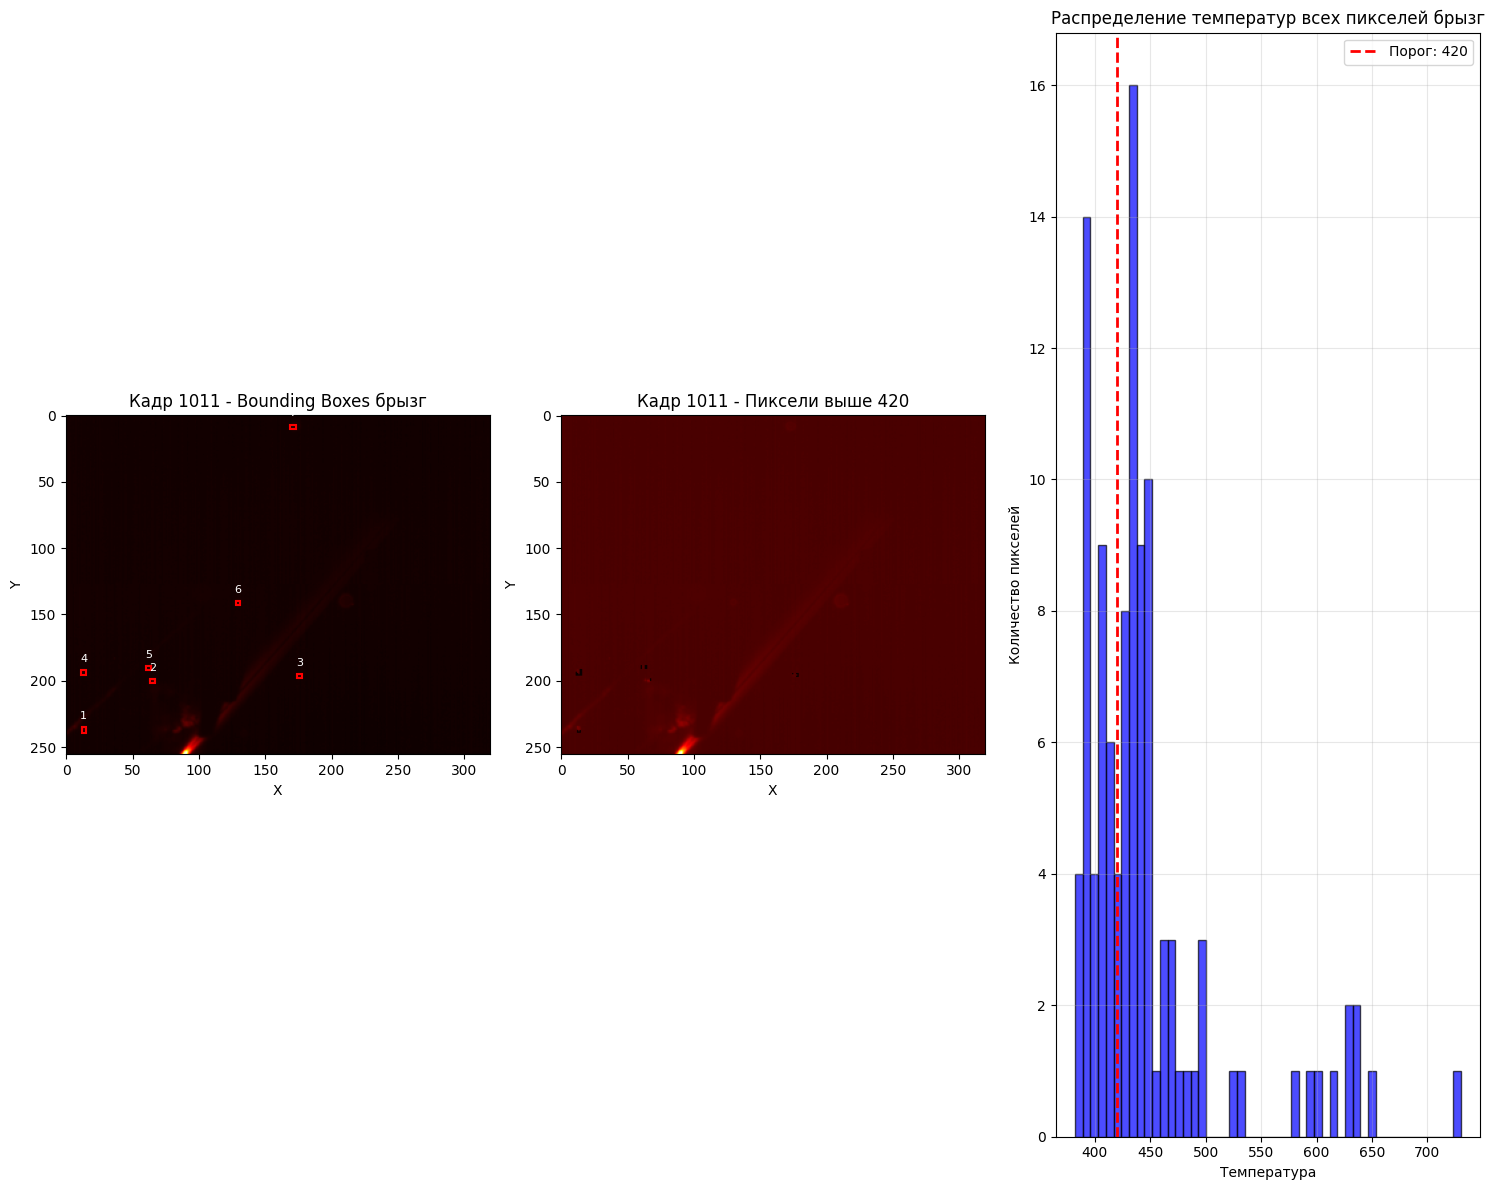

In [20]:
spatter_stats = visualize_spatters_threshold(
    frame_idx=1011,
    cleaned_spatters=cleaned_spatters,
    frames=frames,
    threshold_temp=420,  # МЕНЯЙТЕ ЭТО ЗНАЧЕНИЕ ДЛЯ НАСТРОЙКИ
    max_spatters_to_show=15
)

## Подсчет характеристик, количество и температурные характеристики

In [21]:
df_count_spatters = create_spatters_count_dataframe(cleaned_spatters, thermogram_id=thermogram_id)

df_spatters_median_temperature = calculate_spatters_median_temperature(
    cleaned_spatters=cleaned_spatters,
    frames=frames,
    threshold_temp=420,
)

In [22]:
print(f'Датафрейм с количеством капель df_count_spatters (строки 1110-1115)\n{df_count_spatters.iloc[1110:1116]}')

Датафрейм с количеством капель df_count_spatters (строки 1110-1115)
      frame_number  spatters_count_del  thermogram_id
1110          1111                   5              7
1111          1112                   6              7
1112          1113                   6              7
1113          1114                   7              7
1114          1115                  10              7
1115          1116                   6              7


In [23]:
print(f'Датафрейм с медианной температурой капель (строки 1110-1115)\n{df_spatters_median_temperature.iloc[1110:1116]}')

Датафрейм с медианной температурой капель (строки 1110-1115)
      frame_number  spatters_above_threshold  spatters_median_temperature  \
1110          1111                         4                   433.722222   
1111          1112                         5                   437.363636   
1112          1113                         6                   436.270898   
1113          1114                         7                   449.647059   
1114          1115                         8                   450.890071   
1115          1116                         5                   461.789474   

      spatters_mean_temperature  spatters_max_temperature  \
1110                 441.032986                467.937500   
1111                 442.081061                470.375000   
1112                 446.512016                480.166667   
1113                 454.908483                482.480000   
1114                 448.317540                478.440000   
1115                 457.463728  

## Импорт функции для настройка порога температуры зоны сварки

In [24]:
from Utilities.Calculating_Parameters import visualize_welding_zone_threshold

=== АНАЛИЗ КАДРА 1000 ===
Центр зоны: (95, 238)
Радиус зоны: 50 пикселей
Порог температуры: 1000
Всего пикселей в зоне: 5634
Пикселей выше порога: 98 (1.7%)
Пикселей ниже порога: 5536 (98.3%)
Температура выше порога:
  Средняя: 1857.40
  Максимальная: 4341.00
  Минимальная: 1000.00
  Медианная: 1594.50
Общая статистика зоны:
  Средняя температура всех пикселей: 441.12
  Максимальная температура: 4341.00
  Минимальная температура: 343.00


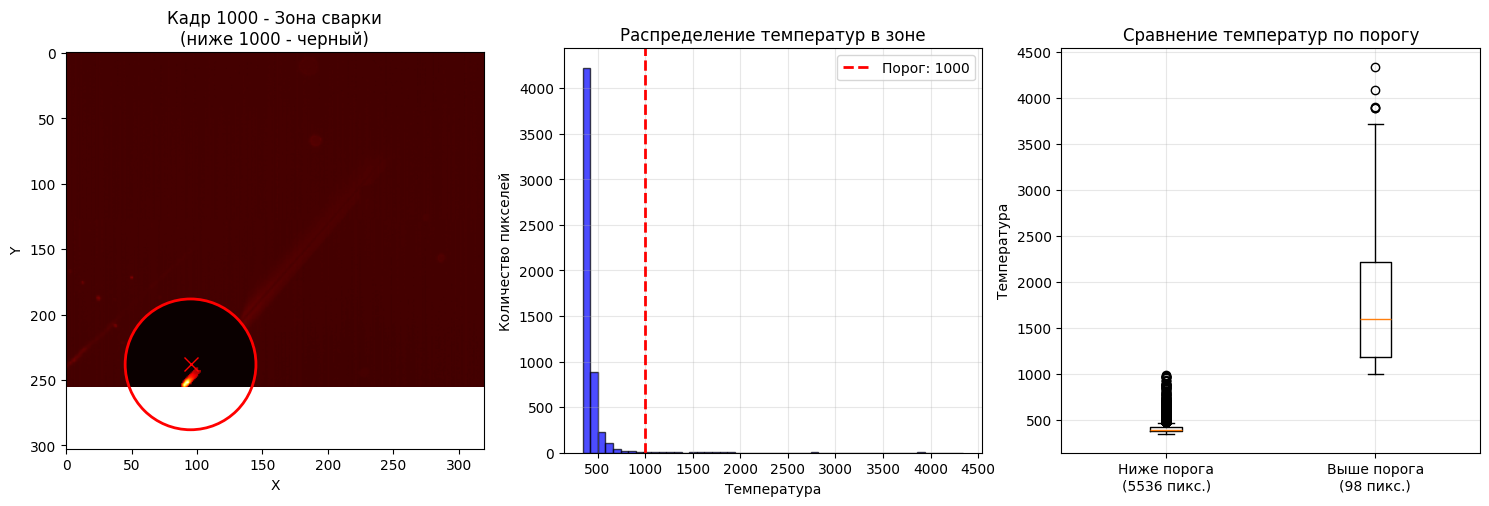

In [25]:
# Использование для настройки порога:
test_frame_idx = 1000  # можно изменить на любой кадр
above_threshold_pixels = visualize_welding_zone_threshold(
    frame_idx=test_frame_idx,
    welding_ellipses=welding_ellipses,  # или welding_ellipses в зависимости от вашей переменной
    frames=frames,
    threshold_temp=1000,  # МЕНЯЙТЕ ЭТО ЗНАЧЕНИЕ ДЛЯ НАСТРОЙКИ
    radius=50            # МЕНЯЙТЕ ЭТО ЗНАЧЕНИЕ ДЛЯ НАСТРОЙКИ
)

## Импорт функции расчета характеристик зоны сварки

In [26]:
from Utilities.Calculating_Parameters import calculate_welding_zone_temperature_threshold

In [27]:
# Использование:
df_welding_temperature = calculate_welding_zone_temperature_threshold(
    welding_ellipses=welding_ellipses, 
    frames=frames, 
    threshold_temp=1000,  # можно менять порог
    radius=50,           # можно менять радиус
    thermogram_id=thermogram_id
)

## Импорт трекера капель

In [28]:
from Utilities.Spatter_Tracker import SpatterTracker, track_spatters_with_ids

In [29]:
# Посмотреть размерность массива кадров
print(f"Размерность frames: {frames.shape}")

# Если frames 3D массив (кадры, высота, ширина)
if frames.ndim == 3:
    print(f"Количество кадров: {frames.shape[0]}")
    print(f"Высота кадра: {frames.shape[1]}")
    print(f"Ширина кадра: {frames.shape[2]}")
    
# Если frames 4D массив (например, с цветовыми каналами)
elif frames.ndim == 4:
    print(f"Количество кадров: {frames.shape[0]}")
    print(f"Высота кадра: {frames.shape[1]}")
    print(f"Ширина кадра: {frames.shape[2]}")
    print(f"Количество каналов: {frames.shape[3]}")


Размерность frames: (1500, 256, 320)
Количество кадров: 1500
Высота кадра: 256
Ширина кадра: 320


## Получаем отслеживаемые брызги и статистику

In [30]:
# Получаем брызги с ID и статистику
cleaned_spatters_id, df_stats = track_spatters_with_ids(
    cleaned_spatters=cleaned_spatters,
    frame_width=320,
    frame_height=256,
    min_movement_distance=5,   # удаляем брызги которые движутся <5px за 3 кадра
    min_movement_frames=3
)

In [31]:
print(f'Датафрейм со статистикой по отслеживанию капель (строки 1110-1115)\n{df_stats.iloc[1110:1116]}')

Датафрейм со статистикой по отслеживанию капель (строки 1110-1115)
      frame_number  spatters_total  spatters_new  spatters_lost  \
1110          1111              11             4              1   
1111          1112              13             3              1   
1112          1113              14             3              2   
1113          1114              16             3              1   
1114          1115              18             6              4   
1115          1116              19             3              2   

      spatters_mean_velocity  spatters_mean_area  
1110                0.537009           16.542841  
1111                1.223521           14.776420  
1112                1.508499           14.977217  
1113                2.346139           17.251425  
1114                2.548999           18.432287  
1115                2.079823           19.442192  


## Просмотр работы трекера 

In [32]:
from Utilities.Show_Video import show_video_with_tracking

In [33]:
show_video_with_tracking(
    frames=frames,
    cleaned_spatters_id=cleaned_spatters_id,
    welding_boxes=welding_boxes,
    welding_ellipses=welding_ellipses,
    fps=25,
    trail_length=15,  # показывать траектории за 15 кадров
    show_trails=True
)

Просмотр трекинга завершен


## Объединяем все датафреймы по frame_number

In [34]:
df_combined = df_count_spatters.merge(
    df_spatters_median_temperature, on='frame_number', how='outer'
).merge(
    df_welding_temperature, on='frame_number', how='outer'
).merge(
    df_stats, on='frame_number', how='outer'
)

In [35]:
df_combined

,frame_number,spatters_count_del,thermogram_id,spatters_above_threshold,spatters_median_temperature,spatters_mean_temperature,spatters_max_temperature,spatters_total_pixels_above_threshold,spatters_percentage_above_threshold,welding_zone_detected,welding_zone_mean_temperature,welding_zone_max_temperature,welding_zone_size,test_zone,spatters_total,spatters_new,spatters_lost,spatters_mean_velocity,spatters_mean_area
0,1,0,7,0,NaN,NaN,NaN,0,0.0,False,NaN,NaN,0,None,0,0,0,0.0,0.0
1,2,0,7,0,NaN,NaN,NaN,0,0.0,False,NaN,NaN,0,None,0,0,0,0.0,0.0
2,3,0,7,0,NaN,NaN,NaN,0,0.0,False,NaN,NaN,0,None,0,0,0,0.0,0.0
3,4,0,7,0,NaN,NaN,NaN,0,0.0,False,NaN,NaN,0,None,0,0,0,0.0,0.0
4,5,0,7,0,NaN,NaN,NaN,0,0.0,False,NaN,NaN,0,None,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1496,0,7,0,NaN,NaN,NaN,0,0.0,True,NaN,NaN,0,None,0,0,0,0.0,0.0
1496,1497,0,7,0,NaN,NaN,NaN,0,0.0,True,NaN,NaN,0,None,0,0,0,0.0,0.0
1497,1498,0,7,0,NaN,NaN,NaN,0,0.0,True,NaN,NaN,0,None,0,0,0,0.0,0.0
1498,1499,0,7,0,NaN,NaN,NaN,0,0.0,True,NaN,NaN,0,None,0,0,0,0.0,0.0


# Потоковая обраотка всех PTW файлов

## Задаем номера термограмм, ptw файлы этих термограмм должны лежать в `'../Data/PTW'`

In [36]:
thermogram_ids = [7, 8]

## Импорт функции для потоковой фильтрации 

In [37]:
from Utilities.Filter_Min_Loc_Log import create_filtered_videos_for_ids

## Фильтрация

In [38]:
processed, skipped, errors = create_filtered_videos_for_ids(
    thermogram_ids=thermogram_ids,
    input_base_path = '../Data/NumPy_convert',
    output_base_path = '../Data/Filtered',
    overwrite_all=False
)


Обработка термограммы 7
✓ Пропускаем термограмму 7 (файл уже существует)

Обработка термограммы 8
✓ Пропускаем термограмму 8 (файл уже существует)

ИТОГИ ОБРАБОТКИ
Всего термограмм в списке: 2
Успешно обработано: 0
Пропущено (уже существуют): 2
Ошибок: 0


## Импорт функции для потокового формирования единого датафрейма для всех термограмм (из списка thermogram_ids)

In [39]:
from Utilities.Streaming_Processing import process_multiple_thermograms_safe

## Потоковая обработка и формирование датафрейма

In [40]:
df_combined_all = process_multiple_thermograms_safe(
    thermogram_ids=thermogram_ids,
    original_base_path='../Data/NumPy_convert',                          # путь к оригиналам
    filtered_base_path='../Data/Filtered',
    save_dir='../Debugging_Information/Progress_Streaming_Processing'    # путь к фильтрованным
)

✓ Загружены обработанные термограммы: 2 шт
✓ Загружены сохраненные данные: 3000 строк
✓ В данных присутствуют термограммы: [np.int64(7), np.int64(8)]

СТАТУС ОБРАБОТКИ
Всего запрошено: 2 термограмм
Уже обработано: 2
Нужно обработать: 0
Обработанные: [7, 8]
✓ Все запрошенные термограммы уже обработаны!


In [41]:
df_combined_all

,frame_number,spatters_count_del,thermogram_id,spatters_above_threshold,spatters_median_temperature,spatters_mean_temperature,spatters_max_temperature,spatters_total_pixels_above_threshold,spatters_percentage_above_threshold,welding_zone_detected,welding_zone_mean_temperature,welding_zone_max_temperature,welding_zone_size,test_zone,spatters_total,spatters_new,spatters_lost,spatters_mean_velocity,spatters_mean_area
0,1,0,7,0,NaN,NaN,NaN,0,0.0,False,NaN,NaN,0,None,0,0,0,0.000000,0.000000
1,2,0,7,0,NaN,NaN,NaN,0,0.0,False,NaN,NaN,0,None,0,0,0,0.000000,0.000000
2,3,0,7,0,NaN,NaN,NaN,0,0.0,False,NaN,NaN,0,None,0,0,0,0.000000,0.000000
3,4,0,7,0,NaN,NaN,NaN,0,0.0,False,NaN,NaN,0,None,0,0,0,0.000000,0.000000
4,5,0,7,0,NaN,NaN,NaN,0,0.0,False,NaN,NaN,0,None,0,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1496,2,8,2,471.430530,471.430530,471.616162,148,100.0,True,NaN,NaN,0,None,5,1,0,2.045699,43.699954
2996,1497,4,8,4,475.722222,475.291111,476.200000,68,100.0,True,NaN,NaN,0,None,6,2,1,1.436695,23.627498
2997,1498,4,8,4,477.555556,476.557029,478.933333,82,100.0,True,NaN,NaN,0,None,4,0,1,0.983907,17.975267
2998,1499,1,8,1,476.600000,476.600000,476.600000,25,100.0,True,NaN,NaN,0,None,4,0,0,0.886652,18.623400


## Импорт функции для загрузки при прерывании потоковой обработки

In [42]:
from Utilities.Streaming_Processing import load_saved_processing_results

## Загрузка

In [43]:
df_combined_all, processed_ids = load_saved_processing_results(save_dir='../Debugging_Information/Progress_Streaming_Processing')

✓ Результаты загружены:
  • Данные: 3000 строк
  • Обработанные термограммы: 2 шт
  • Термограммы в данных: [np.int64(7), np.int64(8)]


## Сохранение итогового тафрейма

In [44]:
df_combined_all.to_csv('../Data/CSV/merge_therm_ids_data_example_7_8.csv')